## 2. Grouping Users together!

### 2.1 Getting your data + feature engineering

In [1]:
import pandas as pd

df = pd.read_csv("vodclickstream_uk_movies_03.csv", usecols=range(1, 8))
df

,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


Let's create the new features suggested in the homework for each user: favorite genre, average click duration, the most active time of the day, whether he is an old or recent movie lover and the average time spent a day.

**1- Favorite gender**

In [2]:
# Convert genres from comma-separated value to a list of values
df['genres_list'] = df['genres'].astype(str).str.split(',')

# Explode the genres list into separate rows
exploded_df = df.explode('genres_list')

# Convert the genres to lowercase and strip them
exploded_df['genres_list'] = exploded_df['genres_list'].str.lower().str.strip()

# Group by 'user_id' and 'genres' and calculate the total duration
genre_total_time = exploded_df.groupby(['user_id', 'genres_list'])['duration'].sum().reset_index()

# Find the most common genre for each user
idx = genre_total_time.groupby('user_id')['duration'].idxmax()
favorite_genre = genre_total_time.loc[idx, ['user_id', 'genres_list']]

# Merge the result back to the original DataFrame
df = pd.merge(df, favorite_genre, on='user_id', how='left', suffixes=('', '_favorite'))

# Rename the columns
df = df.rename(columns={'genres_list_favorite': 'favorite_genre'})

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",comedy
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",drama
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",action
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",action
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Fam...",drama
...,...,...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd,[Talk-Show],talk-show
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba,"[Animation, Action, Adventure, Family, Sci...",action
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a,"[Action, Adventure, Sci-Fi]",drama
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b,"[Documentary, Music]",comedy


**2- Average click duration**

In [3]:
# Find the average click duration for each user
average_click_duration = df.groupby('user_id')['duration'].mean().reset_index(name='avg_click_duration')

# Merge the result with the original DataFrame
df = pd.merge(df, average_click_duration, on='user_id', how='left')

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",comedy,0.000000
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",drama,1553.750000
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",action,4218.666667
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",action,1883.533333
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Fam...",drama,3684.538462
...,...,...,...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd,[Talk-Show],talk-show,851.000000
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba,"[Animation, Action, Adventure, Family, Sci...",action,22533.416667
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a,"[Action, Adventure, Sci-Fi]",drama,502.500000
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b,"[Documentary, Music]",comedy,15072.000000


**3- Time of the day**

In [4]:
# Create bins for dividing the hours of the day: Morning (6-14), Afternoon (14-22), Night(22-6).
bins = [0, 6, 14, 22, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Night']

# Convert 'datetime' column to datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract the corresponding time of the day
df['time_of_day'] = pd.cut(df['datetime'].dt.hour, bins=bins, labels=labels, include_lowest=True, ordered=False)

# Group by 'user_id' and 'time_of_day' and calculate the total duration
sum_time_of_day = df.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()

# Find the most active time of the day for each user
idx = sum_time_of_day.groupby('user_id')['duration'].idxmax()
most_active_time = sum_time_of_day.loc[idx, ['user_id', 'time_of_day']]

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, most_active_time, on=['user_id'], how='left', suffixes=('', '_most_active_time'))

# Rename the columns
df = df.rename(columns={'time_of_day_most_active_time': 'most_active_time'})

# Drop the 'time_of_day' column
df.drop('time_of_day', axis=1, inplace=True)

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",comedy,0.000000,Afternoon
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",drama,1553.750000,Afternoon
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",action,4218.666667,Afternoon
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",action,1883.533333,Afternoon
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Fam...",drama,3684.538462,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd,[Talk-Show],talk-show,851.000000,Afternoon
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba,"[Animation, Action, Adventure, Family, Sci...",action,22533.416667,Afternoon
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a,"[Action, Adventure, Sci-Fi]",drama,502.500000,Afternoon
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b,"[Documentary, Music]",comedy,15072.000000,Night


**4- Old or recent movie lover**

In [5]:
# Convert 'release_date' column to datetime object
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Create a boolean feature 'oldmovie' based on the release date
df['oldmovie'] = df['release_date'].dt.year < 2010

# Group by 'user_id' and count the number of old and new movies
user_oldmovie_counts = df.groupby(['user_id', 'oldmovie'])['movie_id'].count().unstack(fill_value=0)

# Create a new feature 'oldmovie_preference' based on the count
user_oldmovie_counts['oldmovie_preference'] = user_oldmovie_counts[True] > user_oldmovie_counts[False]

# Reset the index to make 'user_id' a regular column
user_oldmovie_counts.reset_index(inplace=True)

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_oldmovie_counts[['user_id', 'oldmovie_preference']],
              on=['user_id'], how='left')

# Drop the 'oldmovie' column
df.drop('oldmovie', axis=1, inplace=True)

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",comedy,0.000000,Afternoon,True
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",drama,1553.750000,Afternoon,False
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",action,4218.666667,Afternoon,False
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",action,1883.533333,Afternoon,False
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Fam...",drama,3684.538462,Afternoon,False
...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd,[Talk-Show],talk-show,851.000000,Afternoon,False
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba,"[Animation, Action, Adventure, Family, Sci...",action,22533.416667,Afternoon,False
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a,"[Action, Adventure, Sci-Fi]",drama,502.500000,Afternoon,False
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b,"[Documentary, Music]",comedy,15072.000000,Night,False


**5- Average time spent a day**

In [6]:
# Column 'datetime' was previously converted to datetime object
# df['datetime'] = pd.to_datetime(df['datetime'])

# Extract the date from the datetime
df['date'] = df['datetime'].dt.date

# Group by 'user_id' and 'date' and calculate the sum of duration for each day
user_daily_duration = df.groupby(['user_id', 'date'])['duration'].sum().reset_index()

# Group by 'user_id' and calculate the mean duration for each user
user_avg_daily_duration = user_daily_duration.groupby('user_id')['duration'].mean().reset_index()

# Rename the columns to reflect the new feature
user_avg_daily_duration.columns = ['user_id', 'avg_daily_duration']

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_avg_daily_duration[['user_id', 'avg_daily_duration']],
              on=['user_id'], how='left')

# Drop the 'date' column
df.drop('date', axis=1, inplace=True)

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",comedy,0.000000,Afternoon,True,0.000000
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",drama,1553.750000,Afternoon,False,18645.000000
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",action,4218.666667,Afternoon,False,8437.333333
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",action,1883.533333,Afternoon,False,9417.666667
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Fam...",drama,3684.538462,Afternoon,False,7369.076923
...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd,[Talk-Show],talk-show,851.000000,Afternoon,False,851.000000
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba,"[Animation, Action, Adventure, Family, Sci...",action,22533.416667,Afternoon,False,45066.833333
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a,"[Action, Adventure, Sci-Fi]",drama,502.500000,Afternoon,False,1256.250000
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b,"[Documentary, Music]",comedy,15072.000000,Night,False,25120.000000


Now, let's consider 10 additional features that can be generated for each user (some of them suggested by ChatGPT):
- Total duration of user engagement
- Average gap between clicks
- Most active day of the week
- Most active on weekends
- Clicks per month
- New releases ratio
- Number of clicks on classic movies
- Average release year
- Average movie duration
- User genre diversity

**6- Total duration of user engagement:** The total duration of time the user has been actively engaging with the platform.

In [7]:
# Group by 'user_id' and calculate the total duration for each user
user_total_duration = df.groupby('user_id')['duration'].sum().reset_index(name='user_total_duration')

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_total_duration, on='user_id', how='left')

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",comedy,0.000000,Afternoon,True,0.000000,0.0
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",drama,1553.750000,Afternoon,False,18645.000000,18645.0
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",action,4218.666667,Afternoon,False,8437.333333,25312.0
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",action,1883.533333,Afternoon,False,9417.666667,28253.0
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Fam...",drama,3684.538462,Afternoon,False,7369.076923,95798.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd,[Talk-Show],talk-show,851.000000,Afternoon,False,851.000000,851.0
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba,"[Animation, Action, Adventure, Family, Sci...",action,22533.416667,Afternoon,False,45066.833333,270401.0
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a,"[Action, Adventure, Sci-Fi]",drama,502.500000,Afternoon,False,1256.250000,5025.0
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b,"[Documentary, Music]",comedy,15072.000000,Night,False,25120.000000,75360.0


**7- Average gap between clicks:** The average time gap between consecutive clicks for each user.

In [8]:
# Column 'datetime' was previously converted to datetime object
# df['datetime'] = pd.to_datetime(df['datetime'])

# Sort the dataframe by 'user_id' and 'datetime'
df.sort_values(by=['user_id', 'datetime'], inplace=True)

# Calculate the time difference between consecutive clicks for each user
df['time_gap'] = df.groupby('user_id')['datetime'].diff()

# Calculate the average time gap for each user
user_avg_time_gap = df.groupby('user_id')['time_gap'].mean().reset_index(name='user_avg_time_gap')

# Convert 'avg_time_gap' to seconds
user_avg_time_gap['avg_time_gap'] = user_avg_time_gap['user_avg_time_gap'].dt.total_seconds()

# Drop the 'time_gap' column
df = df.drop(columns=['time_gap'])

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_avg_time_gap[['user_id', 'avg_time_gap']], on='user_id', how='left')

# Replace NaT values with 0 seconds
df['avg_time_gap'] = df['avg_time_gap'].fillna(0)

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,Afternoon,True,0.000,0.0,0.000000
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2017-09-18 21:03:08,173436.0,Fight Club,Drama,1999-10-15,338abadc17,fffeac83be,[Drama],drama,40606.272727,Afternoon,False,55833.625,446669.0,363218.600000
671732,2017-09-20 21:18:18,129.0,To the Bone,Drama,2017-07-14,5a650007e7,fffeac83be,[Drama],drama,40606.272727,Afternoon,False,55833.625,446669.0,363218.600000
671733,2017-07-23 14:45:12,0.0,Forks Over Knives,Documentary,2013-10-16,9ab62a3f2c,ffff2c5f9e,[Documentary],action,0.000000,Afternoon,False,0.000,0.0,1051.000000
671734,2017-07-23 15:02:43,0.0,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2007-04-20,6467fee6b6,ffff2c5f9e,"[Action, Comedy, Mystery, Thriller]",action,0.000000,Afternoon,False,0.000,0.0,1051.000000


**8- Most active day of the week:** Identify the most common day of the week when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks).

In [9]:
# Column 'datetime' was previously converted to datetime object
# df['datetime'] = pd.to_datetime(df['datetime'])

# Extract the day of the week
df['day_of_week'] = df['datetime'].dt.day_name()

# Group by 'user_id' and 'day_of_week' and calculate total duration
user_daily_duration = df.groupby(['user_id', 'day_of_week'])['duration'].sum().reset_index()

# Find the day of the week with the maximum total duration for each user
max_duration_indices = user_daily_duration.groupby('user_id')['duration'].idxmax()
user_most_active_day = user_daily_duration.loc[max_duration_indices]

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_most_active_day[['user_id', 'day_of_week', 'duration']], 
              on=['user_id'], how='left', suffixes=('', '_most_active_day'))

# Drop the 'duration_most_active_day' column
df.drop('duration_most_active_day', axis=1, inplace=True)

# Rename the new column
df.rename(columns={'day_of_week_most_active_day': 'most_active_day'}, inplace=True)

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,day_of_week,most_active_day
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,Afternoon,True,0.000,0.0,0.000000,Tuesday,Tuesday
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Tuesday,Friday
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Tuesday,Friday
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Tuesday,Friday
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Wednesday,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2017-09-18 21:03:08,173436.0,Fight Club,Drama,1999-10-15,338abadc17,fffeac83be,[Drama],drama,40606.272727,Afternoon,False,55833.625,446669.0,363218.600000,Monday,Monday
671732,2017-09-20 21:18:18,129.0,To the Bone,Drama,2017-07-14,5a650007e7,fffeac83be,[Drama],drama,40606.272727,Afternoon,False,55833.625,446669.0,363218.600000,Wednesday,Monday
671733,2017-07-23 14:45:12,0.0,Forks Over Knives,Documentary,2013-10-16,9ab62a3f2c,ffff2c5f9e,[Documentary],action,0.000000,Afternoon,False,0.000,0.0,1051.000000,Sunday,Sunday
671734,2017-07-23 15:02:43,0.0,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2007-04-20,6467fee6b6,ffff2c5f9e,"[Action, Comedy, Mystery, Thriller]",action,0.000000,Afternoon,False,0.000,0.0,1051.000000,Sunday,Sunday


**9- Most active on weekends:** Compares the duration spend on weekdays to the duration spend on weekends, indicating whether the user is more active during the weekends or not.

In [10]:
# Column 'datetime' was previously converted to datetime object
# df['datetime'] = pd.to_datetime(df['datetime'])

# Day of the week was previously extracted
# df['day_of_week'] = df['datetime'].dt.day_name()

# Map weekdays and weekends
df['is_weekend'] = df['datetime'].dt.dayofweek // 5 == 1

# Group by 'user_id' and calculate total duration for weekdays and weekends
user_weekday_weekend_duration = df.groupby(['user_id', 'is_weekend'])['duration'].sum().unstack().reset_index()

# Identify whether the user is more active on weekdays or weekends
user_weekday_weekend_duration['most_active_on_weekends'] = (
    user_weekday_weekend_duration[False].isna() | 
    (user_weekday_weekend_duration[False] < user_weekday_weekend_duration[True])
)

# Drop the 'day_of_week' and 'is_weekend' columns
df.drop('day_of_week', axis=1, inplace=True)
df.drop('is_weekend', axis=1, inplace=True)


# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_weekday_weekend_duration[['user_id', 'most_active_on_weekends']], on=['user_id'], how='left')

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,Afternoon,True,0.000,0.0,0.000000,Tuesday,False
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2017-09-18 21:03:08,173436.0,Fight Club,Drama,1999-10-15,338abadc17,fffeac83be,[Drama],drama,40606.272727,Afternoon,False,55833.625,446669.0,363218.600000,Monday,False
671732,2017-09-20 21:18:18,129.0,To the Bone,Drama,2017-07-14,5a650007e7,fffeac83be,[Drama],drama,40606.272727,Afternoon,False,55833.625,446669.0,363218.600000,Monday,False
671733,2017-07-23 14:45:12,0.0,Forks Over Knives,Documentary,2013-10-16,9ab62a3f2c,ffff2c5f9e,[Documentary],action,0.000000,Afternoon,False,0.000,0.0,1051.000000,Sunday,True
671734,2017-07-23 15:02:43,0.0,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2007-04-20,6467fee6b6,ffff2c5f9e,"[Action, Comedy, Mystery, Thriller]",action,0.000000,Afternoon,False,0.000,0.0,1051.000000,Sunday,True


**10- Clicks per month:** The average number of clicks a user makes per month, considering only the months he logs in.

In [11]:
# Column 'datetime' was previously converted to datetime object
# df['datetime'] = pd.to_datetime(df['datetime'])

# Extract month from the 'datetime' column
df['month'] = df['datetime'].dt.month

# Group by 'user_id' and 'month' and calculate the number of clicks
clicks_per_month = df.groupby(['user_id', 'month']).size().reset_index(name='clicks_count')

# Calculate the average clicks per month for each user
average_clicks_per_month = clicks_per_month.groupby('user_id')['clicks_count'].mean().reset_index(name='avg_clicks_per_month')

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, average_clicks_per_month, on='user_id', how='left')

# Drop the 'month' column
df.drop('month', axis=1, inplace=True)

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,Afternoon,True,0.000,0.0,0.000000,Tuesday,False,1.0
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False,12.0
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False,12.0
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False,12.0
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2017-09-18 21:03:08,173436.0,Fight Club,Drama,1999-10-15,338abadc17,fffeac83be,[Drama],drama,40606.272727,Afternoon,False,55833.625,446669.0,363218.600000,Monday,False,5.5
671732,2017-09-20 21:18:18,129.0,To the Bone,Drama,2017-07-14,5a650007e7,fffeac83be,[Drama],drama,40606.272727,Afternoon,False,55833.625,446669.0,363218.600000,Monday,False,5.5
671733,2017-07-23 14:45:12,0.0,Forks Over Knives,Documentary,2013-10-16,9ab62a3f2c,ffff2c5f9e,[Documentary],action,0.000000,Afternoon,False,0.000,0.0,1051.000000,Sunday,True,2.0
671734,2017-07-23 15:02:43,0.0,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2007-04-20,6467fee6b6,ffff2c5f9e,"[Action, Comedy, Mystery, Thriller]",action,0.000000,Afternoon,False,0.000,0.0,1051.000000,Sunday,True,2.0


**11- New releases ratio:** The user's interest in staying updated with new releases, calculated by dividing the number of seen movies released within the last month by the total number of films seen by the user.

In [12]:
# Columns 'datetime' and 'release_date' were previously converted to datetime object
# df['datetime'] = pd.to_datetime(df['datetime'])
# df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Filter the DataFrame to include only films with duration > 0.0
filtered_df = df[df['duration'] > 0.0]

# Extract month and year from the 'datetime' and 'release_date' columns
filtered_df['click_month'] = filtered_df['datetime'].dt.to_period('M')
filtered_df['release_month'] = filtered_df['release_date'].dt.to_period('M')

# Count the number of clicks on movies released within the last month for each user
new_releases_clicks = filtered_df[filtered_df['click_month'] == filtered_df['release_month']].groupby('user_id')['movie_id'].count().reset_index(name='new_releases_clicks')

# Count the total number of films seen by each user
total_clicks = filtered_df.groupby('user_id')['movie_id'].count().reset_index(name='total_clicks')

# Merge the two DataFrames to calculate the New Releases ratio
merged_df = pd.merge(total_clicks, new_releases_clicks, on='user_id', how='left')

# Calculate the New Releases ratio
merged_df['new_releases_ratio'] = merged_df['new_releases_clicks'] / merged_df['total_clicks']

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, merged_df[['user_id', 'new_releases_ratio']], on='user_id', how='left')

# Fill NaN values with 0 (in case a user hasn't clicked on any new releases)
df['new_releases_ratio'] = df['new_releases_ratio'].fillna(0)

df

C:\Users\albap\AppData\Local\Temp\ipykernel_20268\2163527816.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['click_month'] = filtered_df['datetime'].dt.to_period('M')
C:\Users\albap\AppData\Local\Temp\ipykernel_20268\2163527816.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['release_month'] = filtered_df['release_date'].dt.to_period('M')


,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,Afternoon,True,0.000,0.0,0.000000,Tuesday,False,1.0,0.0
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2017-09-18 21:03:08,173436.0,Fight Club,Drama,1999-10-15,338abadc17,fffeac83be,[Drama],drama,40606.272727,Afternoon,False,55833.625,446669.0,363218.600000,Monday,False,5.5,0.0
671732,2017-09-20 21:18:18,129.0,To the Bone,Drama,2017-07-14,5a650007e7,fffeac83be,[Drama],drama,40606.272727,Afternoon,False,55833.625,446669.0,363218.600000,Monday,False,5.5,0.0
671733,2017-07-23 14:45:12,0.0,Forks Over Knives,Documentary,2013-10-16,9ab62a3f2c,ffff2c5f9e,[Documentary],action,0.000000,Afternoon,False,0.000,0.0,1051.000000,Sunday,True,2.0,0.0
671734,2017-07-23 15:02:43,0.0,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2007-04-20,6467fee6b6,ffff2c5f9e,"[Action, Comedy, Mystery, Thriller]",action,0.000000,Afternoon,False,0.000,0.0,1051.000000,Sunday,True,2.0,0.0


**12- Number of clicks on classic movies:** Counts the number of clicks on movies released before 2000, indicating an interest in classic films.

In [13]:
# Column release_date' was previously converted to datetime object
# df['release_date'] = pd.to_datetime(df['release_date'])

# Filter the DataFrame to include only films released before 2000
classic_movies_clicks = df[df['release_date'].dt.year < 2000].groupby('user_id')['movie_id'].count().reset_index(name='classic_movies_clicks')

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, classic_movies_clicks, on='user_id', how='left')

# Fill NaN values with 0 (in case a user hasn't clicked on any classic movies)
df['classic_movies_clicks'] = df['classic_movies_clicks'].fillna(0)

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio,classic_movies_clicks
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,Afternoon,True,0.000,0.0,0.000000,Tuesday,False,1.0,0.0,0.0
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0,4.0
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0,4.0
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0,4.0
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,Afternoon,False,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2017-09-18 21:03:08,173436.0,Fight Club,Drama,1999-10-15,338abadc17,fffeac83be,[Drama],drama,40606.272727,Afternoon,False,55833.625,446669.0,363218.600000,Monday,False,5.5,0.0,1.0
671732,2017-09-20 21:18:18,129.0,To the Bone,Drama,2017-07-14,5a650007e7,fffeac83be,[Drama],drama,40606.272727,Afternoon,False,55833.625,446669.0,363218.600000,Monday,False,5.5,0.0,1.0
671733,2017-07-23 14:45:12,0.0,Forks Over Knives,Documentary,2013-10-16,9ab62a3f2c,ffff2c5f9e,[Documentary],action,0.000000,Afternoon,False,0.000,0.0,1051.000000,Sunday,True,2.0,0.0,0.0
671734,2017-07-23 15:02:43,0.0,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2007-04-20,6467fee6b6,ffff2c5f9e,"[Action, Comedy, Mystery, Thriller]",action,0.000000,Afternoon,False,0.000,0.0,1051.000000,Sunday,True,2.0,0.0,0.0


**13- Average release year:** Computes the average release year of movies clicked by the user.

In [14]:
# Column release_date' was previously converted to datetime object
# df['release_date'] = pd.to_datetime(df['release_date'])

# Extract the release year from 'release_date'
df['release_year'] = df['release_date'].dt.year

# Group by 'user_id' and calculate the average release year
user_avg_release_year = df.groupby('user_id')['release_year'].mean().reset_index(name='avg_release_year')

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_avg_release_year, on='user_id', how='left')

# Drop the 'release_year' column
df.drop('release_year', axis=1, inplace=True)

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,...,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio,classic_movies_clicks,avg_release_year
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,...,True,0.000,0.0,0.000000,Tuesday,False,1.0,0.0,0.0,2001.000000
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,...,False,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.750000
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,...,False,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.750000
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,...,False,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.750000
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,...,False,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2017-09-18 21:03:08,173436.0,Fight Club,Drama,1999-10-15,338abadc17,fffeac83be,[Drama],drama,40606.272727,...,False,55833.625,446669.0,363218.600000,Monday,False,5.5,0.0,1.0,2012.090909
671732,2017-09-20 21:18:18,129.0,To the Bone,Drama,2017-07-14,5a650007e7,fffeac83be,[Drama],drama,40606.272727,...,False,55833.625,446669.0,363218.600000,Monday,False,5.5,0.0,1.0,2012.090909
671733,2017-07-23 14:45:12,0.0,Forks Over Knives,Documentary,2013-10-16,9ab62a3f2c,ffff2c5f9e,[Documentary],action,0.000000,...,False,0.000,0.0,1051.000000,Sunday,True,2.0,0.0,0.0,2010.000000
671734,2017-07-23 15:02:43,0.0,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2007-04-20,6467fee6b6,ffff2c5f9e,"[Action, Comedy, Mystery, Thriller]",action,0.000000,...,False,0.000,0.0,1051.000000,Sunday,True,2.0,0.0,0.0,2010.000000


**14- Average movie duration:** Calculates the average duration of the movies seen by a user, when the duration of the click is higher than 0.

In [15]:
# Group by 'user_id' and calculate the average duration for clicks with duration > 0.0
user_avg_movie_duration = df[df['duration'] > 0.0].groupby('user_id')['duration'].mean().reset_index(name='avg_movie_duration')

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_avg_movie_duration, on='user_id', how='left')

# Fill NaN values with 0 (in case a user hasn't seen any movies)
df['avg_movie_duration'] = df['avg_movie_duration'].fillna(0)

df

,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,favorite_genre,avg_click_duration,...,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio,classic_movies_clicks,avg_release_year,avg_movie_duration
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,"[Crime, Drama, Thriller]",crime,0.000000,...,0.000,0.0,0.000000,Tuesday,False,1.0,0.0,0.0,2001.000000,0.0
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,...,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.750000,3470.0
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,...,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.750000,3470.0
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,"[Crime, Drama, Thriller]",action,2024.166667,...,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.750000,3470.0
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,"[Action, Horror, Sci-Fi]",action,2024.166667,...,4858.000,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.750000,3470.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2017-09-18 21:03:08,173436.0,Fight Club,Drama,1999-10-15,338abadc17,fffeac83be,[Drama],drama,40606.272727,...,55833.625,446669.0,363218.600000,Monday,False,5.5,0.0,1.0,2012.090909,44666.9
671732,2017-09-20 21:18:18,129.0,To the Bone,Drama,2017-07-14,5a650007e7,fffeac83be,[Drama],drama,40606.272727,...,55833.625,446669.0,363218.600000,Monday,False,5.5,0.0,1.0,2012.090909,44666.9
671733,2017-07-23 14:45:12,0.0,Forks Over Knives,Documentary,2013-10-16,9ab62a3f2c,ffff2c5f9e,[Documentary],action,0.000000,...,0.000,0.0,1051.000000,Sunday,True,2.0,0.0,0.0,2010.000000,0.0
671734,2017-07-23 15:02:43,0.0,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2007-04-20,6467fee6b6,ffff2c5f9e,"[Action, Comedy, Mystery, Thriller]",action,0.000000,...,0.000,0.0,1051.000000,Sunday,True,2.0,0.0,0.0,2010.000000,0.0


**15- User genre diversity:** measures how diverse a user's taste is in terms of movie genres by counting the number of unique genres a user has interacted with and dividing it by the total number of unique genres overall.

In [16]:
from functools import reduce

# Define a function to calculate the number of unique genres excluding 'NOT AVAILABLE'
def count_unique_genres(genre_list):
    return len(set(filter(lambda genre: genre != 'NOT AVAILABLE', genre_list)))

# Calculate the number of unique genres for each user
user_genre_counts = df.groupby('user_id')['genres_list'].apply(lambda x: count_unique_genres(x.sum())).reset_index(name='user_genre_count')

# Calculate the total number of unique genres overall excluding 'NOT AVAILABLE'
total_unique_genres = len(reduce(lambda x, y: set(x).union(set(y)),  df['genres_list']))-1

# Calculate Genre Diversity for each user
user_genre_counts['genre_diversity_ratio'] = user_genre_counts['user_genre_count'] / total_unique_genres

# Merge the calculated feature back to the original DataFrame
df = pd.merge(df, user_genre_counts[['user_id', 'genre_diversity_ratio']], on=['user_id'], how='left')

# Drop the 'genres_list' column
df.drop('genres_list', axis=1, inplace=True)

df

,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,avg_click_duration,most_active_time,...,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio,classic_movies_clicks,avg_release_year,avg_movie_duration,genre_diversity_ratio
0,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,crime,0.000000,Afternoon,...,0.0,0.000000,Tuesday,False,1.0,0.0,0.0,2001.000000,0.0,0.062500
1,2017-05-23 18:41:44,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,action,2024.166667,Afternoon,...,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.750000,3470.0,0.395833
2,2017-05-23 19:47:31,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,action,2024.166667,Afternoon,...,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.750000,3470.0,0.395833
3,2017-05-23 21:37:40,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,action,2024.166667,Afternoon,...,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.750000,3470.0,0.395833
4,2017-05-24 07:29:07,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,action,2024.166667,Afternoon,...,48580.0,127679.913043,Friday,False,12.0,0.0,4.0,2007.750000,3470.0,0.395833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2017-09-18 21:03:08,173436.0,Fight Club,Drama,1999-10-15,338abadc17,fffeac83be,drama,40606.272727,Afternoon,...,446669.0,363218.600000,Monday,False,5.5,0.0,1.0,2012.090909,44666.9,0.250000
671732,2017-09-20 21:18:18,129.0,To the Bone,Drama,2017-07-14,5a650007e7,fffeac83be,drama,40606.272727,Afternoon,...,446669.0,363218.600000,Monday,False,5.5,0.0,1.0,2012.090909,44666.9,0.250000
671733,2017-07-23 14:45:12,0.0,Forks Over Knives,Documentary,2013-10-16,9ab62a3f2c,ffff2c5f9e,action,0.000000,Afternoon,...,0.0,1051.000000,Sunday,True,2.0,0.0,0.0,2010.000000,0.0,0.104167
671734,2017-07-23 15:02:43,0.0,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2007-04-20,6467fee6b6,ffff2c5f9e,action,0.000000,Afternoon,...,0.0,1051.000000,Sunday,True,2.0,0.0,0.0,2010.000000,0.0,0.104167


### 2.2 Choose your features (variables)!

Now we have plenty of features to work with and since we have many different types of numerical features (as durations, counts, ratios...) we though that normalization could be beneficial.

We decided to use the MinMaxScaler function from scikit-learn, which scales each feature to a range between 0 and 1 to bring all features to the same scale range.

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Select the numerical features to be normalized
features_to_normalize = ['duration', 'avg_click_duration', 'avg_daily_duration', 'user_total_duration', 'avg_time_gap',
                         'avg_clicks_per_month', 'new_releases_ratio', 'classic_movies_clicks', 'avg_movie_duration',
                         'genre_diversity_ratio']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

df_norm = df

# Apply normalization to the selected features
df_norm[features_to_normalize] = scaler.fit_transform(df_norm[features_to_normalize])

df_norm

,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,avg_click_duration,most_active_time,...,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio,classic_movies_clicks,avg_release_year,avg_movie_duration,genre_diversity_ratio
0,2017-12-05 20:39:15,5.483282e-08,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862,crime,8.716925e-08,Afternoon,...,9.439445e-08,0.000000,Tuesday,False,0.000000,0.0,0.000000,2001.000000,0.000000,0.096774
1,2017-05-23 18:41:44,1.621955e-04,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,action,1.765322e-04,Afternoon,...,2.292936e-03,0.006037,Friday,False,0.044959,0.0,0.062500,2007.750000,0.000248,0.612903
2,2017-05-23 19:47:31,8.296205e-05,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,action,1.765322e-04,Afternoon,...,2.292936e-03,0.006037,Friday,False,0.044959,0.0,0.062500,2007.750000,0.000248,0.612903
3,2017-05-23 21:37:40,6.574455e-05,Frailty,"Crime, Drama, Thriller",2002-04-12,7314699c23,000052a0a0,action,1.765322e-04,Afternoon,...,2.292936e-03,0.006037,Friday,False,0.044959,0.0,0.062500,2007.750000,0.000248,0.612903
4,2017-05-24 07:29:07,5.483282e-08,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,6275614f9a,000052a0a0,action,1.765322e-04,Afternoon,...,2.292936e-03,0.006037,Friday,False,0.044959,0.0,0.062500,2007.750000,0.000248,0.612903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671731,2017-09-18 21:03:08,9.510039e-03,Fight Club,Drama,1999-10-15,338abadc17,fffeac83be,drama,3.539705e-03,Afternoon,...,2.108163e-02,0.017173,Monday,False,0.018392,0.0,0.015625,2012.090909,0.003189,0.387097
671732,2017-09-20 21:18:18,7.128266e-06,To the Bone,Drama,2017-07-14,5a650007e7,fffeac83be,drama,3.539705e-03,Afternoon,...,2.108163e-02,0.017173,Monday,False,0.018392,0.0,0.015625,2012.090909,0.003189,0.387097
671733,2017-07-23 14:45:12,5.483282e-08,Forks Over Knives,Documentary,2013-10-16,9ab62a3f2c,ffff2c5f9e,action,8.716925e-08,Afternoon,...,9.439445e-08,0.000050,Sunday,True,0.004087,0.0,0.000000,2010.000000,0.000000,0.161290
671734,2017-07-23 15:02:43,5.483282e-08,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2007-04-20,6467fee6b6,ffff2c5f9e,action,8.716925e-08,Afternoon,...,9.439445e-08,0.000050,Sunday,True,0.004087,0.0,0.000000,2010.000000,0.000000,0.161290


For dimensionality reduction, we though about different methods, but as we have both numerical and categorical variables, we decided that Factor Analysis for Mixed Data (FAMD) could be most suitable since it provides a way to reduce dimensionality while considering the mixed nature of the data.

In [18]:
# Drop all Nan values of the normalized dataframe
df_norm = df_norm.dropna()

# Group the dataframe by 'user_id' and all the extracted features
df_grouped = df_norm[['user_id','favorite_genre', 'avg_click_duration','most_active_time', 'oldmovie_preference',
                      'avg_daily_duration', 'user_total_duration', 'avg_time_gap', 'most_active_day',
                      'most_active_on_weekends', 'avg_clicks_per_month','new_releases_ratio','classic_movies_clicks',
                      'avg_release_year', 'avg_movie_duration', 'genre_diversity_ratio']]

# Drop duplicate values
df_grouped = df_grouped.drop_duplicates()
df_grouped.head()

,user_id,favorite_genre,avg_click_duration,most_active_time,oldmovie_preference,avg_daily_duration,user_total_duration,avg_time_gap,most_active_day,most_active_on_weekends,avg_clicks_per_month,new_releases_ratio,classic_movies_clicks,avg_release_year,avg_movie_duration,genre_diversity_ratio
0,00004e2862,crime,8.716925e-08,Afternoon,True,7.139020e-08,9.439445e-08,0.000000,Tuesday,False,0.000000,0.0,0.000000,2001.00,0.000000,0.096774
1,000052a0a0,action,1.765322e-04,Afternoon,False,3.468850e-04,2.292936e-03,0.006037,Friday,False,0.044959,0.0,0.062500,2007.75,0.000248,0.612903
25,000090e7c8,mystery,8.716925e-08,Afternoon,False,7.139020e-08,9.439445e-08,0.000000,Friday,False,0.000000,0.0,0.000000,2018.00,0.000000,0.096774
26,000118a755,horror,6.537693e-08,Afternoon,False,3.569510e-08,4.719723e-08,0.000210,Thursday,False,0.012262,0.0,0.015625,1976.00,0.000000,0.032258
30,000296842d,drama,8.424363e-04,Night,False,2.759552e-03,3.648770e-03,0.000539,Monday,False,0.028610,1.0,0.000000,2018.00,0.001380,0.129032


In [ ]:
# Install prince if not installed already
# pip install prince

In [19]:
from prince import FAMD

# Select features for FAMD, both numerical and categorical
features_for_famd = ['favorite_genre', 'avg_click_duration','most_active_time', 'oldmovie_preference',
                      'avg_daily_duration', 'user_total_duration', 'avg_time_gap', 'most_active_day',
                      'most_active_on_weekends', 'avg_clicks_per_month','new_releases_ratio','classic_movies_clicks',
                      'avg_release_year', 'avg_movie_duration', 'genre_diversity_ratio']

df_famd = df_grouped[features_for_famd]

# Apply FAMD
famd = FAMD(n_components=6, n_iter=10,random_state=10)
df_famd_result = famd.fit_transform(df_famd)

df_famd_result.head()

component,0,1,2,3,4,5
0,-1.546954,-3.974446,1.164287,1.311297,-1.517347,-0.036610
1,-1.844201,-0.190174,-0.002544,-1.651645,2.636685,-0.665977
25,-1.259768,1.227375,-1.497963,-1.982026,0.999137,1.176427
26,-1.504341,-1.565888,-0.039611,-0.705677,-1.690601,3.444009
30,-1.658830,1.915326,0.054903,-2.703655,0.795014,1.217831


The row coordinates represent the position of each sample (user) in the new component space.

In [20]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,4.897,4.90%,4.90%
1,3.612,3.61%,8.51%
2,3.582,3.58%,12.09%
3,2.916,2.92%,15.01%
4,2.585,2.58%,17.59%
5,2.549,2.55%,20.14%


The eigenvalues represent the variance captured by each component. The Component 0 is the one which captures the most variance, achieving a 4.9% and with the 6 components, the total cumulative variance captured is a 20.14%

In [21]:
famd.row_coordinates(df_famd)

component,0,1,2,3,4,5
0,-1.546954,-3.974446,1.164287,1.311297,-1.517347,-0.036610
1,-1.844201,-0.190174,-0.002544,-1.651645,2.636685,-0.665977
25,-1.259768,1.227375,-1.497963,-1.982026,0.999137,1.176427
26,-1.504341,-1.565888,-0.039611,-0.705677,-1.690601,3.444009
30,-1.658830,1.915326,0.054903,-2.703655,0.795014,1.217831
...,...,...,...,...,...,...
671720,-1.625485,-0.575975,-0.735338,0.681329,-0.965378,1.053200
671721,3.053902,0.639254,-1.057208,-0.671567,1.388095,-0.144350
671722,-1.720279,0.880008,0.368387,-1.460752,1.344662,-0.532812
671733,2.994954,0.250870,-1.261457,0.518941,0.633563,-0.276554


Component loadings represent the relationship between the original variables and the derived components.Each cell in the component_loadings DataFrame represents the contribution of the corresponding variable to the respective component. Positive values indicate a positive relationship, and negative values indicate a negative relationship. Larger absolute values imply a stronger influence.

(Maybe we could remove component loadings, as it doesn't provide much useful information).

In [22]:
famd.column_coordinates_

component,0,1,2,3,4,5
variable,,,,,,
avg_click_duration,0.000076,0.208477,0.539317,0.137134,0.003290,0.001641
avg_daily_duration,0.000090,0.221649,0.569141,0.119265,0.003645,0.001837
user_total_duration,0.001111,0.196682,0.499033,0.008474,0.003329,0.002529
avg_time_gap,0.000160,0.020843,0.015977,0.000102,0.000513,0.000077
avg_clicks_per_month,0.002289,0.009068,0.035758,0.256504,0.000119,0.000727
new_releases_ratio,0.000569,0.034910,0.002267,0.000257,0.000638,0.001513
classic_movies_clicks,0.000422,0.066263,0.107183,0.091791,0.000185,0.001062
avg_release_year,0.000167,0.433905,0.189244,0.001769,0.000765,0.000067
avg_movie_duration,0.000109,0.220568,0.558920,0.120644,0.003357,0.001315


In [23]:
famd.column_contributions_.style.format('{:.0%}')

component,0,1,2,3,4,5
variable,,,,,,
avg_click_duration,0%,6%,15%,5%,0%,0%
avg_daily_duration,0%,6%,16%,4%,0%,0%
user_total_duration,0%,5%,14%,0%,0%,0%
avg_time_gap,0%,1%,0%,0%,0%,0%
avg_clicks_per_month,0%,0%,1%,9%,0%,0%
new_releases_ratio,0%,1%,0%,0%,0%,0%
classic_movies_clicks,0%,2%,3%,3%,0%,0%
avg_release_year,0%,12%,5%,0%,0%,0%
avg_movie_duration,0%,6%,16%,4%,0%,0%


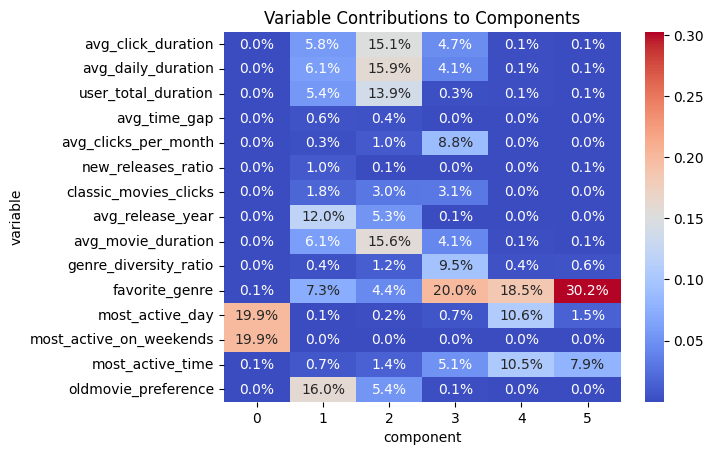

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variable contributions to components using a heatmap
sns.heatmap(famd.column_contributions_, annot=True, fmt=".1%", cmap="coolwarm")
plt.title('Variable Contributions to Components')
plt.show()

Interpretation
- Component 0 seems to be associated with the user's activity patterns, particularly their most active days and whether they are more active on weekends. Users with higher values in this component might exhibit specific preferences regarding when they are most engaged with the platform.
- Component 1 appears to capture aspects related to the preferences for old movies and the average release year of movies clicked by the user. Users with higher values in this component might show preferences for movies released in certain years depending on whether they prefer old or actual movies.
- Users in component 2 are influenced by their average click duration, average daily duration, and total duration. This could represent a group of users who spend a significant amount of time on the platform daily, with a focus on the average duration of each click.
- Component 3 represents a segment of users who have a clear favorite genre but also enjoy exploring content from different genres. They are active participants on the platform, clicking on content frequently, and their viewing choices are influenced by both their favorite genre and a inclination to exploring content from various genres.
- Users in component 4 are users who have a clear preference for a particular genre and that also exhibit a consistent pattern of increased activity on particular days and specific time of day, which suggest a scheduled viewing routine.
- Similarly to the previous component, component 5 represents a segment of users whose behavior is notably characterized by his favorite genre and which have a preferred time of day when they are most active on the platform.

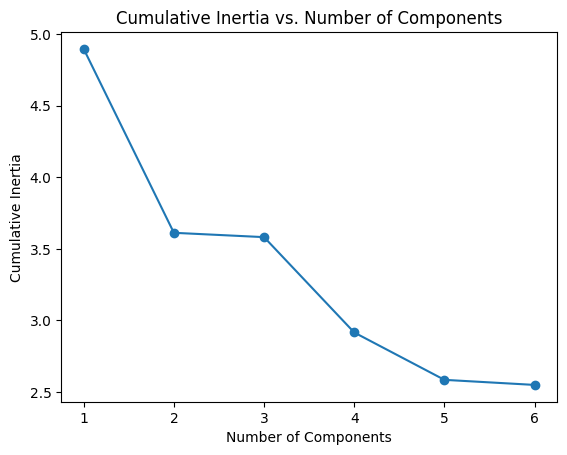

In [27]:
famd_fit=famd.fit(df_famd)
cumulative_inertia = famd_fit.percentage_of_variance_

# Plotting the cumulative inertia
plt.plot(range(1, 7), cumulative_inertia, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Inertia')
plt.title('Cumulative Inertia vs. Number of Components')
plt.show()

As the cumulative inertia hardly decreases from 5 components to 6 components, we decided to apply the FAMD dimensionality reduction method for the first 5 components.

In [28]:
# Accessing the transformed data with five components
reduced_df = df_famd_result.iloc[:, :5]
reduced_df

component,0,1,2,3,4
0,-1.546954,-3.974446,1.164287,1.311297,-1.517347
1,-1.844201,-0.190174,-0.002544,-1.651645,2.636685
25,-1.259768,1.227375,-1.497963,-1.982026,0.999137
26,-1.504341,-1.565888,-0.039611,-0.705677,-1.690601
30,-1.658830,1.915326,0.054903,-2.703655,0.795014
...,...,...,...,...,...
671720,-1.625485,-0.575975,-0.735338,0.681329,-0.965378
671721,3.053902,0.639254,-1.057208,-0.671567,1.388095
671722,-1.720279,0.880008,0.368387,-1.460752,1.344662
671733,2.994954,0.250870,-1.261457,0.518941,0.633563


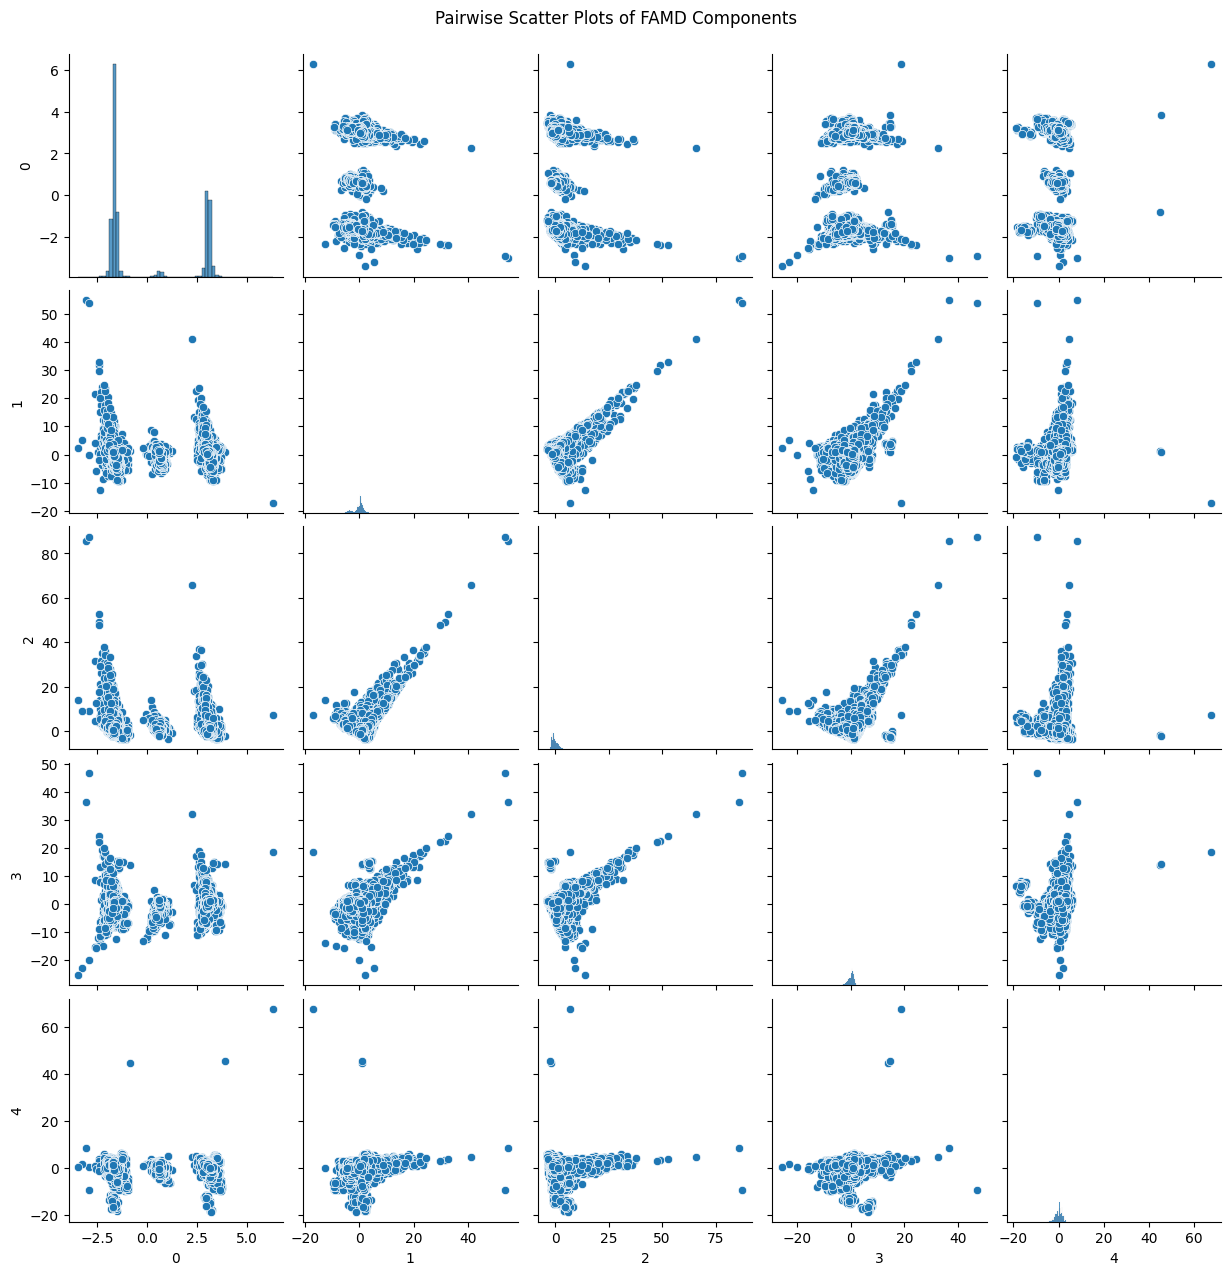

In [29]:
import seaborn as sns

# Plotting pairwise scatter plots
sns.pairplot(reduced_df)
plt.suptitle('Pairwise Scatter Plots of FAMD Components', y=1.02)
plt.show()

In [30]:
reduced_df

component,0,1,2,3,4
0,-1.546954,-3.974446,1.164287,1.311297,-1.517347
1,-1.844201,-0.190174,-0.002544,-1.651645,2.636685
25,-1.259768,1.227375,-1.497963,-1.982026,0.999137
26,-1.504341,-1.565888,-0.039611,-0.705677,-1.690601
30,-1.658830,1.915326,0.054903,-2.703655,0.795014
...,...,...,...,...,...
671720,-1.625485,-0.575975,-0.735338,0.681329,-0.965378
671721,3.053902,0.639254,-1.057208,-0.671567,1.388095
671722,-1.720279,0.880008,0.368387,-1.460752,1.344662
671733,2.994954,0.250870,-1.261457,0.518941,0.633563


### 2.3 Clustering!

1- Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

In [36]:
import numpy as np

def map_reduce_kmeans(data, centroids):
    # Map step: Assign each data point to the nearest centroid
    distances = np.linalg.norm(data[:, None] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    # Reduce step: Calculate the mean to obtain new centroids
    new_centroids = np.array([data[labels == c].mean(axis=0) for c in range(len(centroids))])

    return labels, new_centroids

def custom_kmeans(data, n_clusters, max_iterations):
    # Initialization: Randomly select initial cluster representatives
    representatives = data[np.random.choice(data.shape[0], n_clusters, replace=False)]

    # Execute a fixed number of iterations or until convergence
    for iteration in range(max_iterations):
        # Map-Reduce step
        labels, new_representatives = map_reduce_kmeans(data, representatives)

        # Check for convergence
        if np.allclose(new_representatives, representatives, rtol=0.1):
            print("Convergence found!")
            break

        # Update representatives
        representatives = new_representatives

    return labels, representatives

# Example:
n_clusters_example = 3
max_iterations_example = 10

# Call the K-means function
data = reduced_df.values
labels_result, representatives_result = custom_kmeans(data, n_clusters_example, max_iterations_example)

print("Labels:", labels_result)
print("Representatives:", representatives_result)

Labels: [0 1 1 ... 1 2 0]
Representatives: [[ 0.02651807 -3.0801121   2.09023075  0.2959251  -0.13067515]
 [-1.59008959  0.57567303 -0.42038599 -0.04768136  0.01618669]
 [ 3.01945098  0.66384847 -0.393779   -0.0783359   0.04388312]]


2- Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

Convergence found!
Convergence found!
Convergence found!
Convergence found!


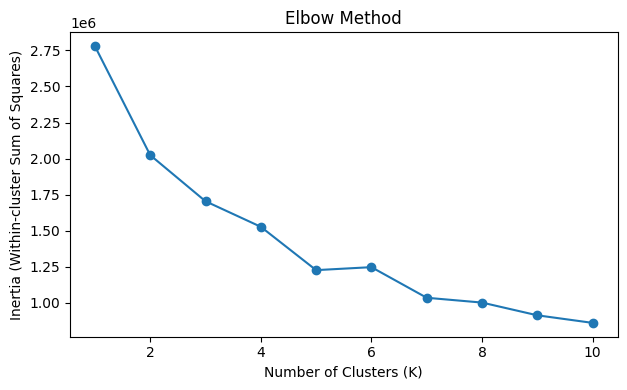

[2779160.477657703, 2023937.8992108097, 1704233.3959122833, 1527197.9066747378, 1226948.4957916816, 1247569.1527537184, 1035442.122853268, 1002085.1909598282, 913851.199956244, 861324.3162911396]


In [37]:
def elbow_method(data, max_clusters=10):
    inertia_values = []

    for k in range(1, max_clusters + 1):
        labels, centroids = custom_kmeans(data, k, max_iterations=10)
        inertia_values.append(np.sum((data - centroids[labels]) ** 2))

    # Plot Elbow Method
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Within-cluster Sum of Squares)')
    plt.title('Elbow Method')

    plt.tight_layout()
    plt.show()

    print(inertia_values)

elbow_method(reduced_df.values, max_clusters=10)

Convergence found!
Convergence found!


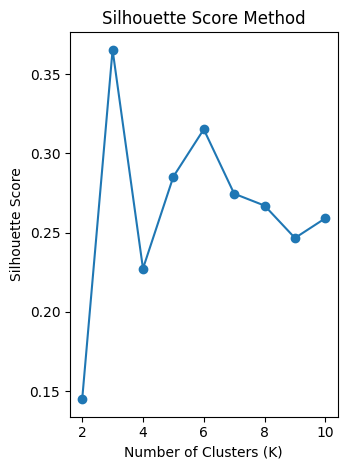

[0.1447955999474438, 0.36546520747861866, 0.22731190087827305, 0.28538201392005336, 0.3152409234595929, 0.2746018899326149, 0.2670837017304955, 0.24661773265047815, 0.2590958691504508]


In [38]:
from sklearn.metrics import silhouette_score

def silhouette_score_method(data, max_clusters=10):
    silhouette_scores = []

    for k in range(2, max_clusters + 1):
        labels, _ = custom_kmeans(data, k, max_iterations=10)
        silhouette_scores.append(silhouette_score(data, labels))

    # Plot Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Method')

    plt.tight_layout()
    plt.show()

    print(silhouette_scores)

silhouette_score_method(reduced_df.values, max_clusters=10)

Elbow Method: The inertia decreases continuously, and there's no clear "elbow." This might suggest that the data doesn't have a distinct, well-separated structure, making it challenging to find a clear elbow. 

Silhouette Score Method: The maximum score occurs at K=2 (0.3655). This suggests that, based on Silhouette Score alone, K=2 might be a good choice.

Considering both methods, K=2 might be a reasonable choice, as it has has a relatively high Silhouette Score although the Elbow Method doesn't show a distinct elbow.

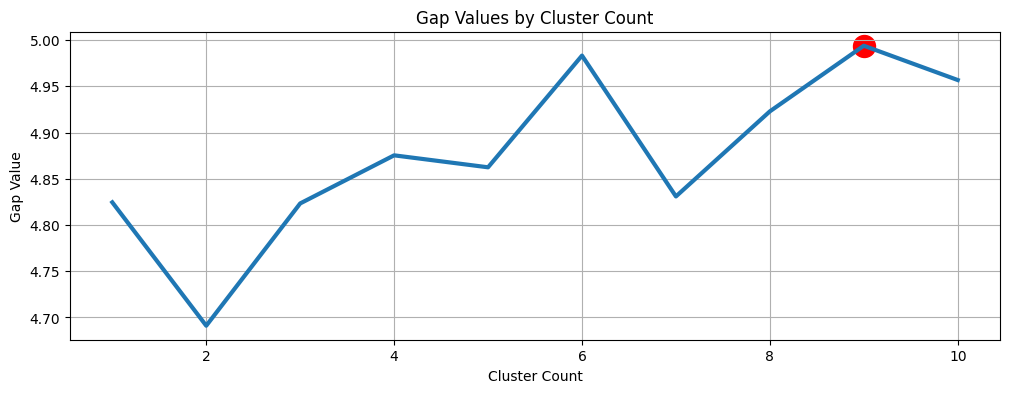

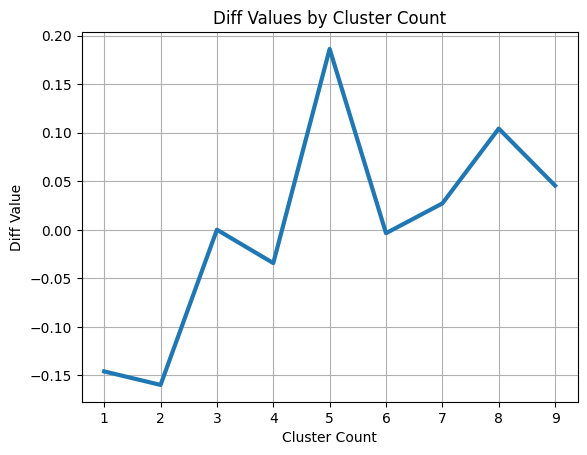

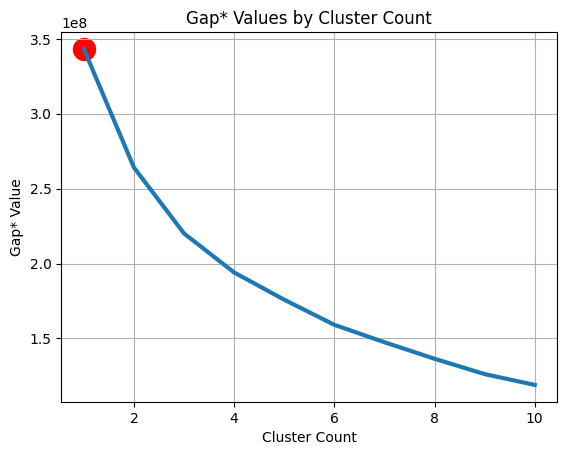

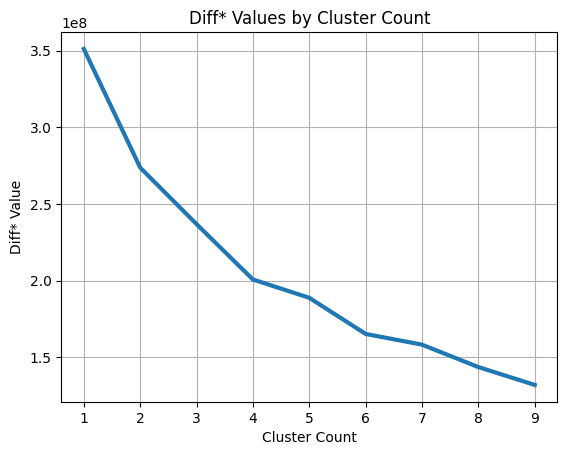

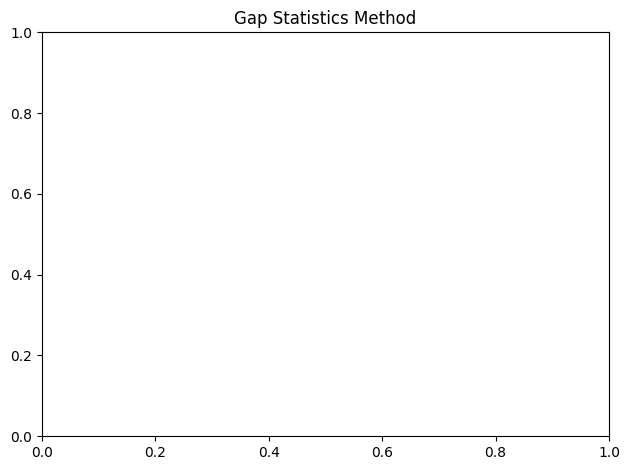

   n_clusters  gap_value  ref_dispersion_std        sk          gap*  \
0         1.0   4.824508        4.241660e+05  0.001286  3.432967e+08   
1         2.0   4.691076        3.842205e+06  0.015029  2.641590e+08   
2         3.0   4.823308        4.245587e+06  0.019590  2.200935e+08   
3         4.0   4.875327        4.555553e+06  0.024429  1.940766e+08   
4         5.0   4.862381        3.474050e+06  0.020365  1.758765e+08   
5         6.0   4.983176        1.952007e+06  0.012772  1.590931e+08   
6         7.0   4.830880        1.741408e+06  0.012268  1.474808e+08   
7         8.0   4.922881        1.727805e+06  0.013264  1.364346e+08   
8         9.0   4.993851        8.697696e+05  0.007168  1.261981e+08   
9        10.0   4.956746        9.580119e+05  0.008379  1.189726e+08   

            sk*      diff         diff*  
0  3.600529e+08 -0.145895  3.510744e+08  
1  2.770816e+08 -0.159822  2.736878e+08  
2  2.308790e+08  0.000085  2.368497e+08  
3  2.036053e+08 -0.034291  2.007472e+08

In [44]:
from gap_statistic import OptimalK

def gap_statistics_method(data, max_clusters=10):
    optimal_k = OptimalK(parallel_backend='multiprocessing')
    cluster_array = np.arange(1, max_clusters + 1)
    optimal_k(X=data, n_refs=10, cluster_array=cluster_array)
    
    # Plot Gap Statistics
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 1, 1)  # Use a single subplot
    optimal_k.plot_results()
    plt.title('Gap Statistics Method')

    plt.tight_layout()
    plt.show()

    print(optimal_k.gap_df)

# Example usage
gap_statistics_method(reduced_df.values, max_clusters=10)

(ChatGPT also suggested the above method but i don't really know how to interpret it and neither I know if it is correct (the last graphic doesn't plot anything)).

3- Run the algorithm on the data obtained from the dimensionality reduction.

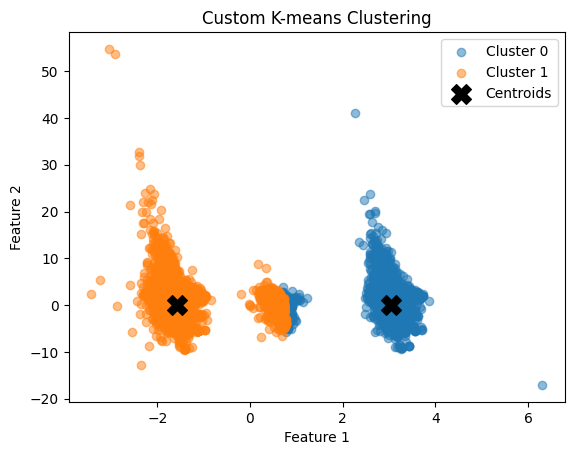

In [58]:
import matplotlib.pyplot as plt

def plot_clusters(data, labels, centroids):
    # Scatter plot for each cluster
    for cluster in np.unique(labels):
        cluster_points = data[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.5)

    # Scatter plot for centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='black', label='Centroids')

    plt.title('Custom K-means Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

labels, centroids = custom_kmeans(reduced_df.values, 2, max_iterations=10)
plot_clusters(reduced_df.values, labels, centroids)